## House Prices Dataset Analysis

### Table of Contents
<ol>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ol>

<a id='intro'></a>
## 1. Introduction

[The Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf) was compiled by Dean De Cock for use in data science education and it's a great a;ternative to the Boston Housing dataset. It describes the sale of individual residential property in Ames, Iowa from 2006 to 2010. This dataset contains only residential sales within the date set, only the most recent sales data on any property. 

The dataset contains 2919 observations separated in:
* training set, with 1460 observations
* testing set, with 1459 observations.

There are 80 features involved in assessing home values, with the target variable included. They focus on the quality and quantity of many physical attributes of the property. 

The features have the following structure:

#### #1 Categorical Variables:

They range from 2 to 28 classes. We should use label encoding for these categorical variables.

* 23 **nominal**: typically identify various types of dwellings, garages, materials, and environmental conditions 
* 23 **ordinal**: ordinal variables typically rate various items within the property. 

**PID**  and **NEIGHBORHOOD** are two features of special interest.

PID (Parcel Identification Number assigned to each property within the Ames Assessor’s system) 
* This number can be used in conjunction with the [Assessor’s Office](http://www.cityofames.org/assessor/) or [Beacon](http://beacon.schneidercorp.com/) websites to directly view the records of a particular observation.
* The typical record will indicate the values for characteristics commonly quoted on most home flyers and will include a picture of the property.
* I must say that PID number was especially useful when trying to fill the missing values.

#### #2 Numeric variables:
* 14 discrete: quantify the number of items occurring within the house:
    * the number of kitchens, bedrooms, and bathrooms (full and half) located in the basement and above grade (ground) living areas of the home, the garage capacity, construction/remodeling dates.
* 19 continuous (area dimensions)
    * typical lot size and total dwelling square footage and other more specific variables are quantified in the data set like: area measurements on the basement, main living area, porches are broken down into individual categories based on quality and type.
    
I have compiled a spreadsheet (features.ods) with all the features with the description for each type of variable: 

* numeric (continuous, discrete) 
* categorical (nominal, ordinal)

### Goal

The goal of this notebook is to understand the Ames Dataset in order to uncover meaningful patterns and insights and model the data to make accurate sale price predictions.
1. First, I will assess and clean the data by: 
    * Categorize features 
    * Fill in missing values
    * Remove outliers 
2. Perform **Exploratory Data Analysis** to visualise how our variables are distributed and how they correlate to each other.
3. Fit the clean data to a simple **Linear Regression Model** in order to make a baseline model for further improvements. Using only two variables I was able to make a simple model with a **Coefficient of Determination  (R Squared)** of about 0.80. I first applied a log transformation on our target variable to make it normally distributed and then I fitted my input variables to the linear model. The two variables used in the regression are the Total Square Footage (`TotalBsmtS`F + `GrLivArea`) and the `Neighborhood`. On the second variable I used one-hot-encoding. The model was evaluated with `Root Mean Squared Error (RMSE)` with a value of about 0.17444 on the training set and 0.19363 on the testing set on the Kaggle House Prices Competition. 
This is just a baseline model which has great room for improvement and creativity on feature engineering. This model used only two features and in the dataset there are 79. Also, there are other models that should be used like XGBoost, CatBoost, LightGBM, ElasticNet and others. Stacking the results of these models and hyperparameter tuning are the next steps for a second more complex model with better predictions.

<a id='wrangling'></a>
## 2 Data Wrangling

Getting the data I need in three steps:
1. Gather 
2. Assess
3. Cleaning

### #2.1. Gather the Data

The data set can be found on Kaggle, the classic ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) competition.

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

In [3]:
# load the dataset
PATH_TO_DATA = 'input'

df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train.csv'), index_col='Id')
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test.csv'), index_col='Id')

### #2 Assesing Data

General properties of the training and testing sets:
* Number of samples in train/test dataset: 1460, 1459
* Number of columns in train/test dataset: 80, 79
* Duplicate rows in each dataset: 0
* Datatypes: float64(3), int64(35), object(43). So, at first look we have 37 numeric variables and 43 categorical variables. Actually, there are 19 continuous features (without the target variable), 14 discrete features, 23 nominal features and 23 ordinal features
* Features with missing values: there are 19 columns in the training set with missing values and 33 in the test set
* Number of non-null unique values for features in training set
* Use the `describe` function for the statistics of the dataset:
    * the count, mean, standard deviation and the 5 number summary for each variable.

In [4]:
# take a look at the first 5 rows of the dataset
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# take a look at the first 5 rows of the dataset
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# number of samples and columns
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [7]:
# check for duplicates
sum(df_train.duplicated()), sum(df_test.duplicated())

(0, 0)

In [8]:
# check the datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

So, at first look we have 37 numeric variables and 43 categorical variables. I'll pay some attention to this, as the variable types are important when modelling our data and making predictions.

#### Features

Let's categorize our features to identify them easier for each of the variable type (numeric and categorical): continuous, discrete, nominal and ordinal.

In [9]:
# column names
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

#### #1.a Continuous Features

In [10]:
# continuous variables
continuous_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

df_train[continuous_features].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
Id,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0


In [11]:
# the number of continuous features
df_test[continuous_features].shape[1]

19

#### #1.b Discrete Features

In [12]:
# discrete variables
discrete_features = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                     'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']
# check the filter
df_train[discrete_features].head()

,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
Id,,,,,,,,,,,,,,
1,2003,2003,1,0,2,1,3,1,8,0,2003.0,2,2,2008
2,1976,1976,0,1,2,0,3,1,6,1,1976.0,2,5,2007
3,2001,2002,1,0,2,1,3,1,6,1,2001.0,2,9,2008
4,1915,1970,1,0,1,0,3,1,7,1,1998.0,3,2,2006
5,2000,2000,1,0,2,1,4,1,9,1,2000.0,3,12,2008


In [13]:
# the number of discrete features
df_test[discrete_features].shape[1]

14

#### #2.a Nominal Features

In [14]:
# nominal variables
nominal_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 
                    'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                    'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature',
                    'SaleType', 'SaleCondition']

# check the filter
df_train[nominal_features].head()

,MSSubClass,MSZoning,Street,Alley,Utilities,LotConfig,Neighborhood,Condition1,Condition2,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,PavedDrive,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,AllPub,Inside,CollgCr,Norm,Norm,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,Y,NaN,WD,Normal
2,20,RL,Pave,NaN,AllPub,FR2,Veenker,Feedr,Norm,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,Attchd,Y,NaN,WD,Normal
3,60,RL,Pave,NaN,AllPub,Inside,CollgCr,Norm,Norm,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,Y,NaN,WD,Normal
4,70,RL,Pave,NaN,AllPub,Corner,Crawfor,Norm,Norm,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,Detchd,Y,NaN,WD,Abnorml
5,60,RL,Pave,NaN,AllPub,FR2,NoRidge,Norm,Norm,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,Y,NaN,WD,Normal


In [15]:
# the number of continuous features
df_test[nominal_features].shape[1]

23

#### #2.b Ordinal Features

In [16]:
# ordinal variables
ordinal_features = ['LotShape', 'LandContour', 'LandSlope', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 
                    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
                    'PoolQC', 'Fence']

# check the filter
df_train[ordinal_features].head()

,LotShape,LandContour,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
Id,,,,,,,,,,,,,,,,,,,,,,,
1,Reg,Lvl,Gtl,1Fam,2Story,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,Typ,NaN,RFn,TA,TA,NaN,NaN
2,Reg,Lvl,Gtl,1Fam,1Story,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,TA,Typ,TA,RFn,TA,TA,NaN,NaN
3,IR1,Lvl,Gtl,1Fam,2Story,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Gd,Typ,TA,RFn,TA,TA,NaN,NaN
4,IR1,Lvl,Gtl,1Fam,2Story,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Gd,Typ,Gd,Unf,TA,TA,NaN,NaN
5,IR1,Lvl,Gtl,1Fam,2Story,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Gd,Typ,TA,RFn,TA,TA,NaN,NaN


In [17]:
# the number of continuous features
df_test[ordinal_features].shape[1]

23

In [18]:
# test to check if all the columns are included
list(continuous_features + discrete_features + nominal_features + ordinal_features).sort() == list(df_test.columns).sort() 

True

#### Nulls in training set

In [19]:
# check for missing values
df_train.isnull().sum()[df_train.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [20]:
# the number 
nuls_columns = list(df_train.isnull().sum()[df_train.isnull().sum() > 0].index)
len(nuls_columns)

19

There are 19 columns with nuls in the training set. Let's identify the variable types with nuls because we have to figure out the reason why this variables are left blank in order to fill them with appropriate values.

We can see that there are some particular columns with really high number of nulls. For example, the `Alley` feature has 1369 nuls and only 91 non-nulls value. Same goes for `PoolQC`, `Fence`, `MiscFeature` and possibly `FireplaceQu`

In [21]:
# nuls in continuous features
continuous_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in continuous_features]
continuous_nuls

['LotFrontage', 'MasVnrArea']

In [22]:
# nuls in discrete features
discrete_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in discrete_features]
discrete_nuls

['GarageYrBlt']

In [23]:
# nuls in nominal features
nominal_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in nominal_features]
nominal_nuls

['Alley', 'MasVnrType', 'Electrical', 'GarageType', 'MiscFeature']

In [24]:
# nuls in ordinal features
ordinal_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in ordinal_features]
ordinal_nuls

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence']

In the training set, we have nulls in 19 columns: 2 continuous, 1 discrete, 5 nominal and 11 ordinal columns. 

#### Nulls in testing set

In [25]:
# check for missing values
df_test.isnull().sum()[df_test.isnull().sum() > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

Same for the testing set, we can see the features: `Alley`, `PoolQC`, `Fence`, `MiscFeature` and `FireplaceQu` have lots of nulls. I'll look at these variable to figure out the reason for this.

In [26]:
# the number of variables with nulls
nuls_columns = list(df_test.isnull().sum()[df_test.isnull().sum() > 0].index)
len(nuls_columns)

33

We can see that there are 14 more variables with nuls in the testing set. Let's identify them.

In [27]:
# nuls in continuous features
continuous_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in continuous_features]
continuous_nuls

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageArea']

In [28]:
# nuls in discrete features
discrete_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in discrete_features]
discrete_nuls

['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars']

In [29]:
# nuls in nominal features
nominal_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in nominal_features]
nominal_nuls

['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'GarageType',
 'MiscFeature',
 'SaleType']

In [30]:
# nuls in ordinal features
ordinal_nuls = [nul_columns for nul_columns in nuls_columns if nul_columns in ordinal_features]
ordinal_nuls

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence']

In the testing set, we have nuls in 33 columns: 7 continuous features, 4 discrete column, 9 nominal columns and 13 ordinal columns. 

#### Nulls in Categorical variables 

Looking at the description for each variable I found that 'NA' stands for:

* `Alley`: No alley access
* `GarageType`: No Garage
* `MiscFeature`: None
* `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`: No Basement
* `FireplaceQu`: No Fireplace
* `Pool quality`, `PoolQC`: No pool
* `GarageFinish`, `GarageQual`, `GarageCond`: No Garage
* `Fence`: No Fence

These should be replaced by other variables in order to account for them when encoding our features.


Some other features with Nulls that require further investigations: `MSZoning`, `Utilities`, `Exterior1st`, `Exterior2nd`, `MasVnrType`, `SaleType`, `Functional`.

#### Non-null unique values

In [31]:
# let's filter only for discrete, nominal and ordinal features
unique_filter =  discrete_features + nominal_features + ordinal_features

In [32]:
# non-null unique values for ordinal features
df_train[ordinal_features].nunique()

LotShape         4
LandContour      4
LandSlope        3
BldgType         5
HouseStyle       8
OverallQual     10
OverallCond      9
ExterQual        4
ExterCond        5
BsmtQual         4
BsmtCond         4
BsmtExposure     4
BsmtFinType1     6
BsmtFinType2     6
HeatingQC        5
KitchenQual      4
Functional       7
FireplaceQu      5
GarageFinish     3
GarageQual       5
GarageCond       5
PoolQC           3
Fence            4
dtype: int64

In [33]:
# non-null unique values for nominal features
df_train[nominal_features].nunique()

MSSubClass       15
MSZoning          5
Street            2
Alley             2
Utilities         2
LotConfig         5
Neighborhood     25
Condition1        9
Condition2        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
Foundation        6
Heating           6
CentralAir        2
Electrical        5
GarageType        6
PavedDrive        3
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [34]:
# non-null unique values for nominal features
df_train[discrete_features].nunique()

YearBuilt       112
YearRemodAdd     61
BsmtFullBath      4
BsmtHalfBath      3
FullBath          4
HalfBath          3
BedroomAbvGr      8
KitchenAbvGr      4
TotRmsAbvGrd     12
Fireplaces        4
GarageYrBlt      97
GarageCars        5
MoSold           12
YrSold            5
dtype: int64

In [35]:
df_train[discrete_features].head()

,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
Id,,,,,,,,,,,,,,
1,2003,2003,1,0,2,1,3,1,8,0,2003.0,2,2,2008
2,1976,1976,0,1,2,0,3,1,6,1,1976.0,2,5,2007
3,2001,2002,1,0,2,1,3,1,6,1,2001.0,2,9,2008
4,1915,1970,1,0,1,0,3,1,7,1,1998.0,3,2,2006
5,2000,2000,1,0,2,1,4,1,9,1,2000.0,3,12,2008


In [36]:
# non-null unique values differences between training and testing set
df_diff_features = df_train[unique_filter].nunique() - df_test[unique_filter].nunique()
df_diff_features = df_diff_features[df_diff_features != 0]
df_diff_features

YearBuilt       6
FullBath       -1
BedroomAbvGr    1
KitchenAbvGr    1
Fireplaces     -1
GarageCars     -1
MSSubClass     -1
Utilities       1
Condition2      3
RoofMatl        4
Exterior1st     2
Exterior2nd     1
Heating         2
Electrical      1
MiscFeature     1
HouseStyle      1
GarageQual      1
PoolQC          1
dtype: int64

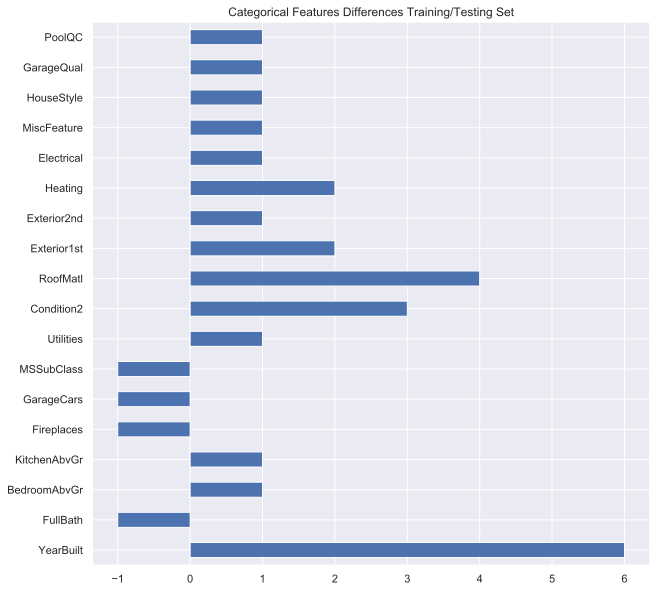

In [37]:
df_diff_features.plot(kind='barh', figsize=(10, 10));
plt.title('Categorical Features Differences Training/Testing Set')
plt.show()

We can see there are some differences between the unique values from training set to testing set. It's important to assess the differences since we want our model to make predictions on similar data. It is tough to predict values if we don't have training examples.

#### Dataset Statistics

In [38]:
# describe the dataset
df_train[continuous_features + ['SalePrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.00,0.0,728.00,2065.0
LowQualFinSF,1460.0,5.844521,48.623081,0.0,0.00,0.0,0.00,572.0


### #2 Cleaning the Data

* The dataset is pretty clean but we do need to fill in the missing values and remove potential outliers that can affect our Linear Model.

#### Fillna for categorical variables

From the dataset description, the missing values in these categorical features: 'Alley', 'GarageType', 'MiscFeature', 'FireplaceQu', 'Fence', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC', 'GarageFinish', 'GarageQual', 'GarageCond', means `None`

In [39]:
for feat in ['Alley', 'GarageType', 'MiscFeature', 'FireplaceQu', 'Fence']:
    # fill NaNs
    df_train[feat].fillna(f'No{feat}', inplace=True)
    df_test[feat].fillna(f'No{feat}', inplace=True)
    print(f'{feat}...done')

Alley...done
GarageType...done
MiscFeature...done
FireplaceQu...done
Fence...done


In [40]:
# test for training set
df_train[['Alley', 'GarageType', 'MiscFeature', 'FireplaceQu', 'Fence']].isnull().sum()

Alley          0
GarageType     0
MiscFeature    0
FireplaceQu    0
Fence          0
dtype: int64

In [41]:
# check for testing set 
df_test[['Alley', 'GarageType', 'MiscFeature', 'FireplaceQu', 'Fence']].isnull().sum()

Alley          0
GarageType     0
MiscFeature    0
FireplaceQu    0
Fence          0
dtype: int64

In [42]:
# fill for no basement
for feat in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    # fill NaNs
    df_train[feat].fillna(f'NoBasement', inplace=True)
    df_test[feat].fillna(f'NoBasement', inplace=True)
    print(f'{feat}...done')

BsmtQual...done
BsmtCond...done
BsmtExposure...done
BsmtFinType1...done
BsmtFinType2...done


In [43]:
# test for train
df_train[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

In [44]:
# and testing set
df_test[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

In [45]:
# fill for no pool
df_train['PoolQC'].fillna(f'NoPool', inplace=True)
df_test['PoolQC'].fillna(f'NoPool', inplace=True)

In [46]:
df_train['PoolQC'].isnull().sum(), df_test['PoolQC'].isnull().sum()

(0, 0)

In [47]:
# fill for no garage
for feat in ['GarageFinish', 'GarageQual', 'GarageCond']:
    # fill NaNs
    df_train[feat].fillna(f'NoGarage', inplace=True)
    df_test[feat].fillna(f'NoGarage', inplace=True)
    print(f'{feat}...done')

GarageFinish...done
GarageQual...done
GarageCond...done


In [48]:
# test for train
df_train[['GarageFinish', 'GarageQual', 'GarageCond']].isnull().sum()

GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [49]:
# and testing set
df_test[['GarageFinish', 'GarageQual', 'GarageCond']].isnull().sum()

GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [50]:
# check again for missing values
df_test[nominal_features+ordinal_features].isnull().sum()[df_test.isnull().sum() > 0]

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
MasVnrType     16
SaleType        1
KitchenQual     1
Functional      2
dtype: int64

In [51]:
# check for missing values
df_train[nominal_features+ordinal_features].isnull().sum()[df_train.isnull().sum() > 0]

MasVnrType    8
Electrical    1
dtype: int64

We are left now with the above variables to fill in missing values for categorical features. We can see there are more missing values in the testing set than in the training set. Let's see if we can figure out why they are not filled.

After looking online, I found [here]( http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls ) the original version of the dataset and I could easily extract the information for the `MSZoning` and other features.
Let's make the changes manually.

#### MsZoning

In [52]:
# let's see the entries
df_test[df_test['MSZoning'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,NoAlley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NoFireplaceQu,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2009,ConLD,Normal
2217,20,NaN,80.0,14584,Pave,NoAlley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NoFireplaceQu,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Abnorml
2251,70,NaN,NaN,56600,Pave,NoAlley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NoFireplaceQu,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2008,WD,Normal
2905,20,NaN,125.0,31250,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NoFireplaceQu,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2006,WD,Normal


In [53]:
df_test.loc[df_test[df_test['MSZoning'].isnull()].index, 'MSZoning']

Id
1916    NaN
2217    NaN
2251    NaN
2905    NaN
Name: MSZoning, dtype: object

In [54]:
# index variable
MSZoning_null_index = list(df_test[df_test['MSZoning'].isnull()].index)

In [55]:
df_test.loc[MSZoning_null_index[0], 'MSZoning'] = 'I'
df_test.loc[MSZoning_null_index[1], 'MSZoning'] = 'A'
df_test.loc[MSZoning_null_index[2], 'MSZoning'] = 'A'
df_test.loc[MSZoning_null_index[3], 'MSZoning'] = 'I'

In [56]:
# test the changes
df_test['MSZoning'].isnull().sum()

0

In [57]:
df_train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [58]:
df_test['MSZoning'].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
A             2
I             2
Name: MSZoning, dtype: int64

Differences 
Because there are no Industrial and Agricultural examples in our testing set, I will reassign these to 
* I -> RH (Residential High Density)
* A -> RL (Residential Low Density)

In [59]:
# reassign values
df_test.loc[MSZoning_null_index[0], 'MSZoning'] = 'RH'
df_test.loc[MSZoning_null_index[1], 'MSZoning'] = 'RL'
df_test.loc[MSZoning_null_index[2], 'MSZoning'] = 'RL'
df_test.loc[MSZoning_null_index[3], 'MSZoning'] = 'RH'

In [60]:
# plot categorical feature differences between training and testing set
def plot_bar(feature):
    width = 0.35
    ind = np.arange(df_test[feature].value_counts().shape[0])
    locations = ind + width / 2 # ytick locations
    labels = list(df_test[feature].value_counts().index) # ytick labels

    heights_test = list(df_test[feature].value_counts().values)
    heights_train = list(df_train[feature].value_counts().values)
    plot_test = plt.bar(ind, heights_test, width, label='Test')
    plot_train = plt.bar(ind + width, heights_train, width, label='Train')

    plt.title('{} Bar Chart'.format(feature))
    plt.xlabel('{}'.format(feature))
    plt.ylabel('')
    plt.xticks(locations, labels)

    plt.legend()
    plt.show()

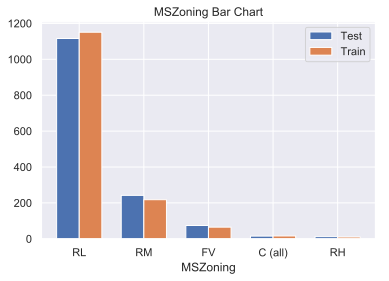

In [61]:
plot_bar('MSZoning')

From the above bar chart we can see the two distribution for zone classification are similar.

#### Utilities

In [62]:
df_test[df_test['Utilities'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1916,30,RH,109.0,21780,Grvl,NoAlley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NoFireplaceQu,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2009,ConLD,Normal
1946,20,RL,NaN,31220,Pave,NoAlley,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NoPool,NoFence,Shed,750,5,2008,WD,Normal


In [63]:
# index variable
Utilities_null_index = list(df_test[df_test['Utilities'].isnull()].index)
Utilities_null_index

[1916, 1946]

In [64]:
# assign the new values
df_test.loc[Utilities_null_index, 'Utilities'] = 'NoSewr'

In [65]:
# test the changes
df_test['Utilities'].isnull().sum()

0

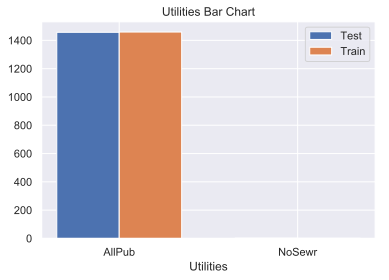

In [66]:
plot_bar('Utilities')

In [67]:
df_test['Utilities'].value_counts()

AllPub    1457
NoSewr       2
Name: Utilities, dtype: int64

In [68]:
df_train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Here there are some differences between the two features, with two `NoSewr` values in the testing set and one `NoSeWa` in the training set.

#### Exterior1st

In [69]:
df_test[df_test['Exterior1st'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2152,30,RL,85.0,19550,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NoGarageType,NaN,NoGarage,0.0,0.0,NoGarage,NoGarage,Y,0,39,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2008,WD,Normal


In [70]:
# index variable
Exterior1st_null_index = df_test[df_test['Exterior1st'].isnull()].index[0]

This observation has more missing values. Let's fill them all.

In [71]:
# reassign values
df_test.loc[Exterior1st_null_index, 'Exterior1st'] ='PreCast'
df_test.loc[Exterior1st_null_index, 'Exterior2nd'] ='PreCast'
df_test.loc[Exterior1st_null_index, 'GarageYrBlt'] ='NoGarage'

In [72]:
df_test[df_test['Exterior2nd'].isnull()].shape

(0, 79)

#### SaleType

In [73]:
df_test[df_test['SaleType'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2490,20,RL,85.0,13770,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,10,2007,NaN,Normal


In [74]:
# index variable
SaleType_null_index = df_test[df_test['SaleType'].isnull()].index[0]

In [75]:
df_test.loc[SaleType_null_index, 'SaleType'] ='VWD'

In [76]:
df_test[df_test['SaleType'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [77]:
df_test['SaleType'].value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
ConLw       3
Con         3
VWD         1
Name: SaleType, dtype: int64

In [78]:
df_train['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [79]:
# I'll put it in the Oth category in order to have similar structure
df_test.loc[SaleType_null_index, 'SaleType'] ='Oth'

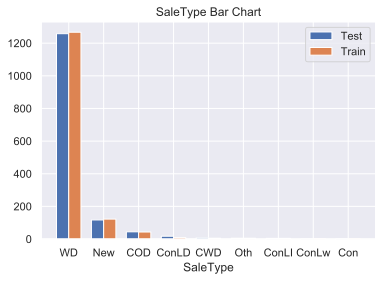

In [80]:
plot_bar('SaleType')

#### KitchenQual

In [81]:
df_test[df_test['KitchenQual'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1556,50,RL,72.0,10632,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,NoFireplaceQu,Detchd,1917,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2010,COD,Normal


In [82]:
# index variable
KitchenQual_null_index = df_test[df_test['KitchenQual'].isnull()].index[0]

In [83]:
#df_test.loc[KitchenQual_null_index, 'KitchenQual'] = 'Po'
# reassign value to match distributions
df_test.loc[KitchenQual_null_index, 'KitchenQual'] = 'Fa'

In [84]:
df_test['KitchenQual'].value_counts()

TA    757
Gd    565
Ex    105
Fa     32
Name: KitchenQual, dtype: int64

In [85]:
df_train['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

#### Functional

In [86]:
df_test[df_test['Functional'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2217,20,RL,80.0,14584,Pave,NoAlley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NoFireplaceQu,Attchd,1952,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Abnorml
2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NoFireplaceQu,Detchd,1910,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NoPool,NoFence,NoMiscFeature,0,9,2007,COD,Abnorml


In [87]:
# index variable
Functional_null_index = list(df_test[df_test['Functional'].isnull()].index)

In [88]:
df_test.loc[Functional_null_index[0], 'Functional'] = 'Sev'
df_test.loc[Functional_null_index[1], 'Functional'] = 'Sev'

These where Sal (Salvage Only) but in order to have the same structure I put them in Sev (Severely Damaged)

In [89]:
df_train['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [90]:
df_test['Functional'].value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        3
Name: Functional, dtype: int64

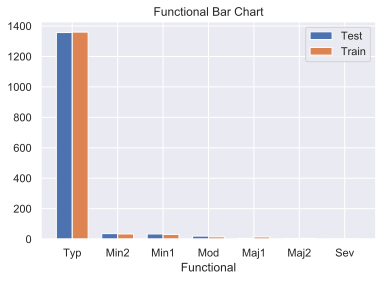

In [91]:
plot_bar('Functional')

#### Electrical

In [92]:
df_train[df_train['Electrical'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1380,80,RL,73.0,9735,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NoFireplaceQu,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2008,WD,Normal,167500


In [93]:
# index variable
Electrical_null_index = df_train[df_train['Electrical'].isnull()].index[0]

In [94]:
df_train.loc[Electrical_null_index, 'Electrical'] = 'SBrkr'

In [95]:
df_train['Electrical'].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [96]:
df_test['Electrical'].value_counts()

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

#### Nulls in Numeric variables

There are also Nuls in continuous variables:
* `LotFrontage`, `MasVnrArea`, `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `GarageArea`: maybe fill them with the mean values to not affect the distributions of values.

Discrete Null values:
* `BsmtFullBath`, `BsmtHalfBath`, `GarageYrBlt`, `GarageCars`

#### MasVnrType  and MasVnrArea

* MasVnrArea - None
* MasVnrType - 0

In [97]:
df_train[df_train['MasVnrType'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
235,60,RL,NaN,7851,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2010,WD,Normal,216500
530,20,RL,NaN,32668,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2007,WD,Alloca,200624
651,60,FV,65.0,8125,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NoFireplaceQu,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2008,WD,Normal,205950
937,20,RL,67.0,10083,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NoFireplaceQu,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2009,WD,Normal,184900
974,20,FV,95.0,11639,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NoFireplaceQu,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,12,2008,New,Partial,182000
978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NoFireplaceQu,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2007,New,Partial,199900
1244,20,RL,107.0,13891,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,9,2006,New,Partial,465000
1279,60,RL,75.0,9473,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,3,2008,WD,Normal,237000


In [98]:
df_test[df_test['MasVnrType'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1692,60,RL,NaN,12891,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002,Fin,3.0,644.0,TA,TA,Y,0,48,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2009,WD,Normal
1707,20,FV,90.0,7993,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,1436.0,1436.0,GasA,Ex,Y,SBrkr,1436,0,0,1436,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NoFireplaceQu,Attchd,2008,Fin,2.0,529.0,TA,TA,Y,0,121,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,10,2009,New,Partial
1883,60,RL,70.0,8749,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,840.0,840.0,GasA,Ex,Y,SBrkr,840,885,0,1725,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NoFireplaceQu,Attchd,2002,RFn,2.0,550.0,TA,TA,Y,0,48,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,11,2009,WD,Normal
1993,60,RL,NaN,7750,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,707.0,707.0,GasA,Ex,Y,SBrkr,707,707,0,1414,0.0,0.0,2,1,3,1,Gd,6,Typ,1,Gd,Attchd,2002,Fin,2.0,403.0,TA,TA,Y,100,35,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2008,WD,Normal
2005,20,RL,87.0,10037,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Feedr,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,666.0,Unf,0.0,794.0,1460.0,GasA,Ex,Y,SBrkr,1460,0,0,1460,0.0,0.0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2006,Fin,2.0,480.0,TA,TA,Y,0,20,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2008,WD,Normal
2042,60,FV,NaN,7500,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Ex,Y,SBrkr,952,860,0,1812,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,2002,RFn,2.0,469.0,TA,TA,Y,144,112,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2008,WD,Normal
2312,60,RL,59.0,15810,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,6,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,768.0,768.0,GasA,Ex,Y,SBrkr,768,728,0,1496,0.0,0.0,3,0,3,1,Gd,7,Typ,0,NoFireplaceQu,Attchd,2007,Unf,2.0,572.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2007,New,Partial
2326,80,RL,NaN,11950,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,SLvl,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Ex,Y,SBrkr,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,BuiltIn,2003,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,10,2007,WD,Normal
2341,20,RL,85.0,9965,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Somerst,Feedr,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1528.0,1528.0,GasA,Ex,Y,SBrkr,1528,0,0,1528,0.0,0.0,3,2,3,1,Gd,6,Typ

In [99]:
# index variable
MasVnrType_null_index = list(df_train[df_train['MasVnrType'].isnull()].index)
MasVnrType_null_index

[235, 530, 651, 937, 974, 978, 1244, 1279]

The properties with `None`, `MasVnrType` have `0`, `MasVnrArea`.

In [100]:
# assign values
df_train.loc[MasVnrType_null_index, 'MasVnrArea'] = 0
df_train.loc[MasVnrType_null_index, 'MasVnrType'] = 'None'

In [101]:
MasVnrType_null_index = list(df_test[df_test['MasVnrType'].isnull()].index)

df_test.loc[MasVnrType_null_index, 'MasVnrArea'] = 0
df_test.loc[MasVnrType_null_index, 'MasVnrType'] = 'None'

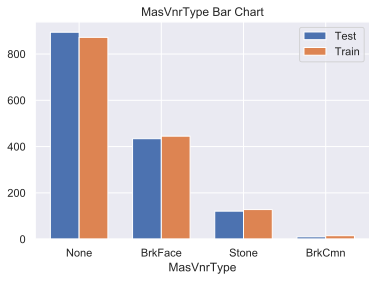

In [102]:
plot_bar('MasVnrType')

#### Continuous Features Nulls

In [103]:
df_test[continuous_features + discrete_features].isnull().sum()[df_test[continuous_features + discrete_features].isnull().sum() > 0]

LotFrontage     227
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageArea        1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      77
GarageCars        1
dtype: int64

In [104]:
df_train[continuous_features + discrete_features].isnull().sum()[df_train[continuous_features + discrete_features].isnull().sum() > 0]

LotFrontage    259
GarageYrBlt     81
dtype: int64

#### LotFrontage

In [105]:
# Fill LotFrontage with mean
df_train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

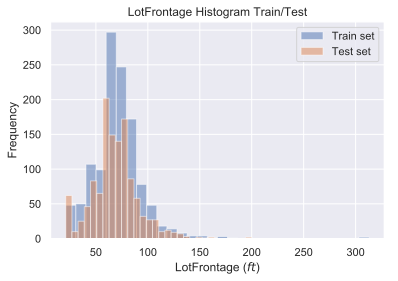

In [106]:
plt.hist(df_train['LotFrontage'], bins=30, alpha=0.5, label='Train set')
plt.hist(df_test['LotFrontage'], bins=30, alpha=0.5, label='Test set')

plt.title("LotFrontage Histogram Train/Test")
plt.xlabel('LotFrontage ($ft$)')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [107]:
# median value LotFrontage
LotFrontage_null_fill = df_train['LotFrontage'].mode()[0]
# fill nans for training and testing set
df_train['LotFrontage'].fillna(LotFrontage_null_fill, inplace=True)
df_test['LotFrontage'].fillna(LotFrontage_null_fill, inplace=True)

In [108]:
df_train['LotFrontage'].isnull().sum(), df_test['LotFrontage'].isnull().sum()

(0, 0)

#### GarageYrBlt

In [109]:
df_train[df_train['GarageYrBlt'].isnull()][:10]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40,90,RL,65.0,6040,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NoBasement,NoBasement,NoBasement,NoBasement,0,NoBasement,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,N,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2008,WD,AdjLand,82000
49,190,RM,33.0,4456,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,N,0,0,102,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2009,New,Partial,113000
79,90,RL,72.0,10778,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,4,2010,WD,Normal,136500
89,50,C (all),105.0,8470,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,N,0,0,156,0,0,0,NoPool,MnPrv,NoMiscFeature,0,10,2009,ConLD,Abnorml,85000
90,20,RL,60.0,8070,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,Y,0,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2007,WD,Normal,123600
100,20,RL,77.0,9320,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,Fa,Y,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,Y,352,0,0,0,0,0,NoPool,NoFence,Shed,400,1,2010,WD,Normal,128950
109,50,RM,85.0,8500,Pave,NoAlley,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,TA,N,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,N,0,0,144,0,0,0,NoPool,NoFence,NoMiscFeature,0,8,2007,WD,Normal,115000
126,190,RM,60.0,6780,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,Gd,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,NoFireplaceQu,NoGarageType,NaN,NoGarage,0,0,NoGarage,NoGarage,N,53,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2006,WD,Normal,84500
128,45,RM,55.0,4388,Pave,NoAlley,IR1,Bnk,AllPub,Inside,Gtl,OldTown

In [110]:
GarageYrBlt_null_vals_train = list(df_train[df_train['GarageYrBlt'].isnull()].index)
GarageYrBlt_null_vals_test = list(df_test[df_test['GarageYrBlt'].isnull()].index)

In [111]:
df_train.loc[GarageYrBlt_null_vals_train, 'GarageYrBlt'] = 'NoGarage'
df_test.loc[GarageYrBlt_null_vals_test, 'GarageYrBlt'] = 'NoGarage'

In [112]:
df_train['GarageYrBlt'].isnull().sum(), df_test['GarageYrBlt'].isnull().sum()

(0, 0)

In [113]:
df_test[continuous_features + discrete_features].isnull().sum()[df_test[continuous_features + discrete_features].isnull().sum() > 0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
GarageArea      1
BsmtFullBath    2
BsmtHalfBath    2
GarageCars      1
dtype: int64

#### GarageArea & GarageCars

In [114]:
df_test[df_test['GarageArea'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2577,70,RM,50.0,9060,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NoFireplaceQu,Detchd,NoGarage,NoGarage,NaN,NaN,NoGarage,NoGarage,Y,174,0,212,0,0,0,NoPool,MnPrv,NoMiscFeature,0,3,2007,WD,Alloca


In [115]:
GarageArea_null_index = df_test[df_test['GarageArea'].isnull()].index[0]

In [116]:
df_test.loc[GarageArea_null_index, 'GarageCars'] = 0
df_test.loc[GarageArea_null_index, 'GarageArea'] = 0

#### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF,  TotalBsmtSF, BsmtFullBath, BsmtHalfBath

In [117]:
df_test[df_test['BsmtFullBath'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,NoAlley,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NoBasement,NoBasement,NoBasement,NoBasement,NaN,NoBasement,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NoFireplaceQu,Detchd,1946,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,4,2008,ConLD,Abnorml
2189,20,RL,123.0,47007,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NoBasement,NoBasement,NoBasement,NoBasement,0.0,NoBasement,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,7,2008,WD,Normal


In [118]:
BsmtFullBath_nulls_index = list(df_test[df_test['BsmtFullBath'].isnull()].index)
mask_bsm = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
df_test.loc[BsmtFullBath_nulls_index, mask_bsm] = 0

In [119]:
df_test[mask_bsm].isnull().sum()

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [120]:
# check to see if we cleaned for nulls
df_train.isnull().sum()[df_train.isnull().sum() > 0], df_test.isnull().sum()[df_train.isnull().sum() > 0]

(Series([], dtype: int64), Series([], dtype: int64))

#### Remove Outliers

* Remove from the training set and testing set the observations with a `GrLivArea` > 4,000. It is important to delete these values as Linear Regression is sensitive to outliers. 
* We have to be aware that there is an extreme data point in the testing set as well which we cannot remove.  

In [121]:
# let's see the four observations with GrLivArea bigger the 4000 
# from the training set
df_test[df_test['GrLivArea'] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2550,20,RL,128.0,39290,Pave,NoAlley,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NoPool,NoFence,NoMiscFeature,17000,10,2007,New,Partial


In [122]:
# let's see the four observations with GrLivArea bigger the 4000 
# from the training set
df_train[df_train['GrLivArea'] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NoAlley,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,10,2007,New,Partial,184750
692,60,RL,104.0,21535,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,1,2007,WD,Normal,755000
1183,60,RL,160.0,15623,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NoMiscFeature,0,7,2007,WD,Abnorml,745000
1299,60,RL,313.0,63887,Pave,NoAlley,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NoFence,NoMiscFeature,0,1,2008,New,Partial,160000


In [123]:
# drop the rows with extreme values
df_train.drop(df_train[df_train['GrLivArea'] > 4000].index, inplace=True)

In [124]:
# test the change
df_train[df_train['GrLivArea'] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [125]:
# reset index
df_train = df_train.reset_index(drop=True)
# check the shape of our dataframe
df_train.shape

(1456, 80)

In [126]:
# rename the index column
df_train.index.names = ['Id'] 

In [127]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFireplaceQu,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000


In [128]:
# save this for later
df_train.to_csv(os.path.join(PATH_TO_DATA, 'train_clean.csv'), sep=',', index_label='Id')
df_test.to_csv(os.path.join(PATH_TO_DATA, 'test_clean.csv'), sep=',', index_label='Id')

In [129]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFireplaceQu,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000


In [130]:
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_clean.csv'), index_col='Id')
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_clean.csv'), index_col='Id')
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFireplaceQu,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000


<a id='eda'></a>
## Exploratory Data Analysis

Let’s visualize the information in our dataset by finding correlation between our variables and see how the data is distributed.

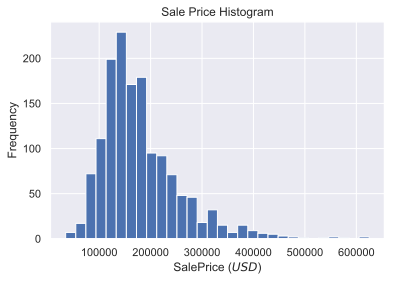

In [131]:
plt.hist(df_train['SalePrice'], bins=30)
plt.title("Sale Price Histogram")
plt.xlabel('SalePrice ($USD$)')
plt.ylabel('Frequency')

plt.show()

The Sale Price Histogram is right skewed, ranging from 34,900 USD to 755,000 USD. The median sale price is 163,000 which might indicate there are some potential outliers or extreme values that can cause bias to our model if we don't eliminate them.

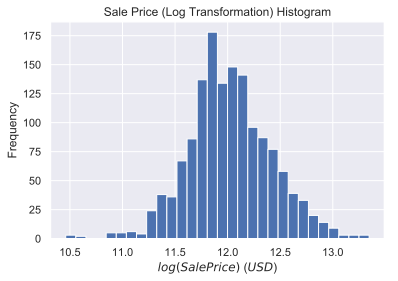

In [132]:
plt.hist(np.log(df_train['SalePrice']), bins=30)
plt.title("Sale Price (Log Transformation) Histogram")
plt.xlabel('$log(SalePrice)$ ($USD$)')
plt.ylabel('Frequency')

plt.show()

Applying a log transformation on the Sale Price we can now see that our distribution is now more normal.

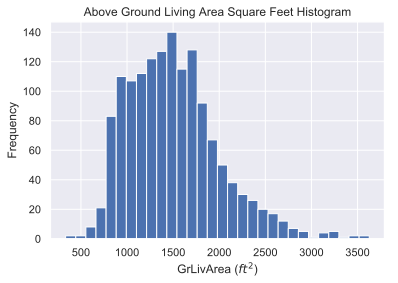

In [133]:
plt.hist(df_train['GrLivArea'], bins=30)
plt.title("Above Ground Living Area Square Feet Histogram")
plt.xlabel('GrLivArea ($ft^{2}$)')
plt.ylabel('Frequency')

plt.show()

`GrLivArea` (above ground living area square feet) ranges from 334 to a maximum value of 3627 $ft^{2}$. From the above histogram of Above Ground Living Area we can see that most properties have a living area between 1,128 and 1,775 $ft^{2}$, with a median 1,458 $ft^{2}$.  

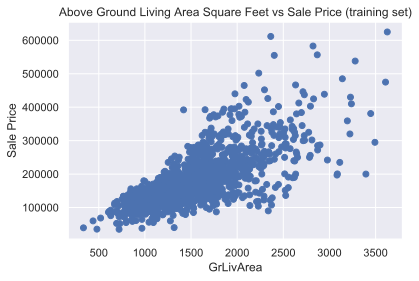

In [134]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice)
plt.title("Above Ground Living Area Square Feet vs Sale Price (training set)")
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')
plt.show()

Removing the outliers now we can better see the strong linear relation between Sale Price and Above Ground Living Area.

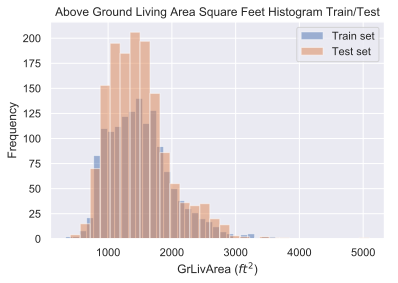

In [135]:
plt.hist(df_train['GrLivArea'], bins=30, alpha=0.5, label='Train set')
plt.hist(df_test['GrLivArea'], bins=30, alpha=0.5, label='Test set')

plt.title("Above Ground Living Area Square Feet Histogram Train/Test")
plt.xlabel('GrLivArea ($ft^{2}$)')
plt.ylabel('Frequency')

plt.legend()
plt.show()

From the above histogram, we can see that the training and testing set distributions of Above Ground Living Area are similar with the difference that in the testing set there is one extreme value.

#### Sale Price Over Time Period

In [136]:
# group data by year and month
df_time_price = df_train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean()
# see the first rows
df_time_price.head()

,YrSold,MoSold,SalePrice
0,2006,1,201090.000000
1,2006,2,194322.222222
2,2006,3,184982.200000
3,2006,4,174312.814815
4,2006,5,158928.289474


We don't have 2010 data for all year round. Therefore, we need to create some 0 data for vizualization purpose and append it to our dataframe.  

In [137]:
mean_2010 = df_time_price[df_time_price['YrSold'] == 2010]['SalePrice'].mean()
mean_2010

170716.15400313973

In [138]:
# create data with median value
new_dummy_df2010 = pd.DataFrame(np.array([[2010, 8, mean_2010], [2010, 9, mean_2010], [2010, 10, mean_2010], 
                       [2010, 11, mean_2010], [2010, 12, mean_2010]]),
                   columns=['YrSold', 'MoSold', 'SalePrice'], index=[55, 56, 57, 58, 59])
new_dummy_df2010

,YrSold,MoSold,SalePrice
55,2010.0,8.0,170716.154003
56,2010.0,9.0,170716.154003
57,2010.0,10.0,170716.154003
58,2010.0,11.0,170716.154003
59,2010.0,12.0,170716.154003


In [139]:
# append the new data
df_time_price = df_time_price.append(new_dummy_df2010)

In [140]:
years = list(range(2006,2011))
labels = list(range(1, 13))

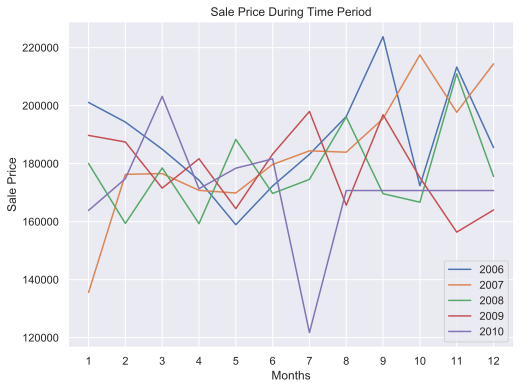

In [141]:
plt.figure(figsize=(8, 6))

for year in years:
    plt.plot(labels, df_time_price[df_time_price['YrSold'] == year]['SalePrice'], label=year)

plt.title('Sale Price During Time Period')
plt.xticks(labels)
plt.xlabel('Months')
plt.ylabel('Sale Price')
plt.legend()
plt.show()

From the above line plot we can see monthly average `SalePrice` from 2006 to 2010. We don't have data for 8-12 months of 2010, so they are filled with the mean value. The biggest sales with a mean value of more then 220,000 USD were recorded in September of 2006 while the worst month was in July of 2010. We can see that, typically, the last four months of the year are more profitable.

#### Correlation Matrix

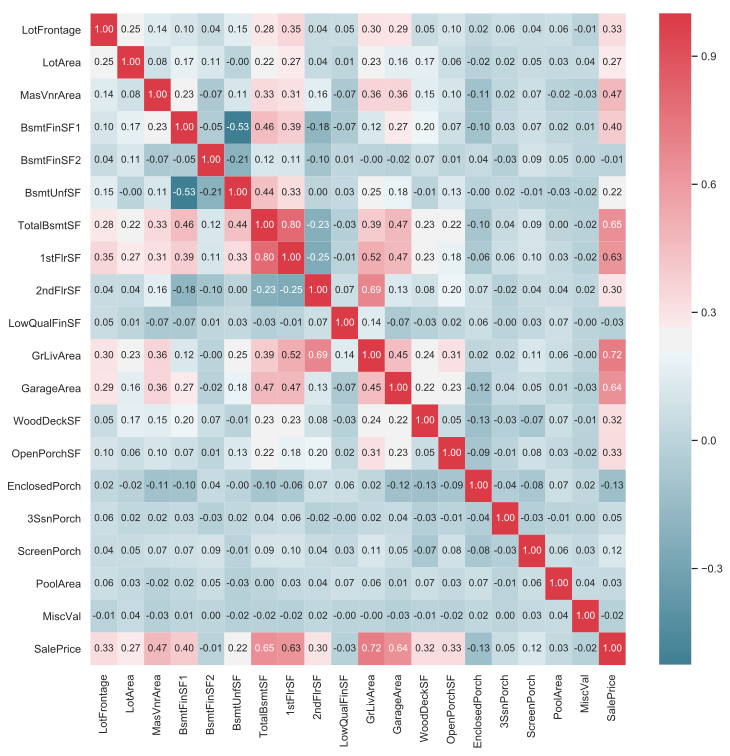

In [142]:
# calculate correlation matrix
corr = df_train[continuous_features + ['SalePrice']].corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(12, 12))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
g = sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
# plt.xticks(range(len(corr.columns)), corr.columns);
# #Apply yticks
# plt.yticks(range(len(corr.columns)), corr.columns)
# #show plot
plt.show()

From the above carrelation matrix, we can see that our target variable, `SalePrice`, has a strong positive linear relationship with `GrLivArea`. ALso, a moderate positive linear relationship with:  
* `TotalBsmtSF`(0.65)
* `GarageArea`(0.64)
* `1stFlrSF`(0.63) + `2ndFlrSF`(0.3) + `LowQualFinSF`= GrLivArea (that's why they correlate with each)
* `MasVnrArea`(0.47)
* `BsmtFinSF1` (0.4)
* `LotFrontage` (0.34)
* `OpenPorchSF` (0.33)
* `WoodDeckSF` (0.32)

BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF

In [143]:
imp_cont_features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'MasVnrArea', 'LotFrontage', 
                     'OpenPorchSF', 'WoodDeckSF']

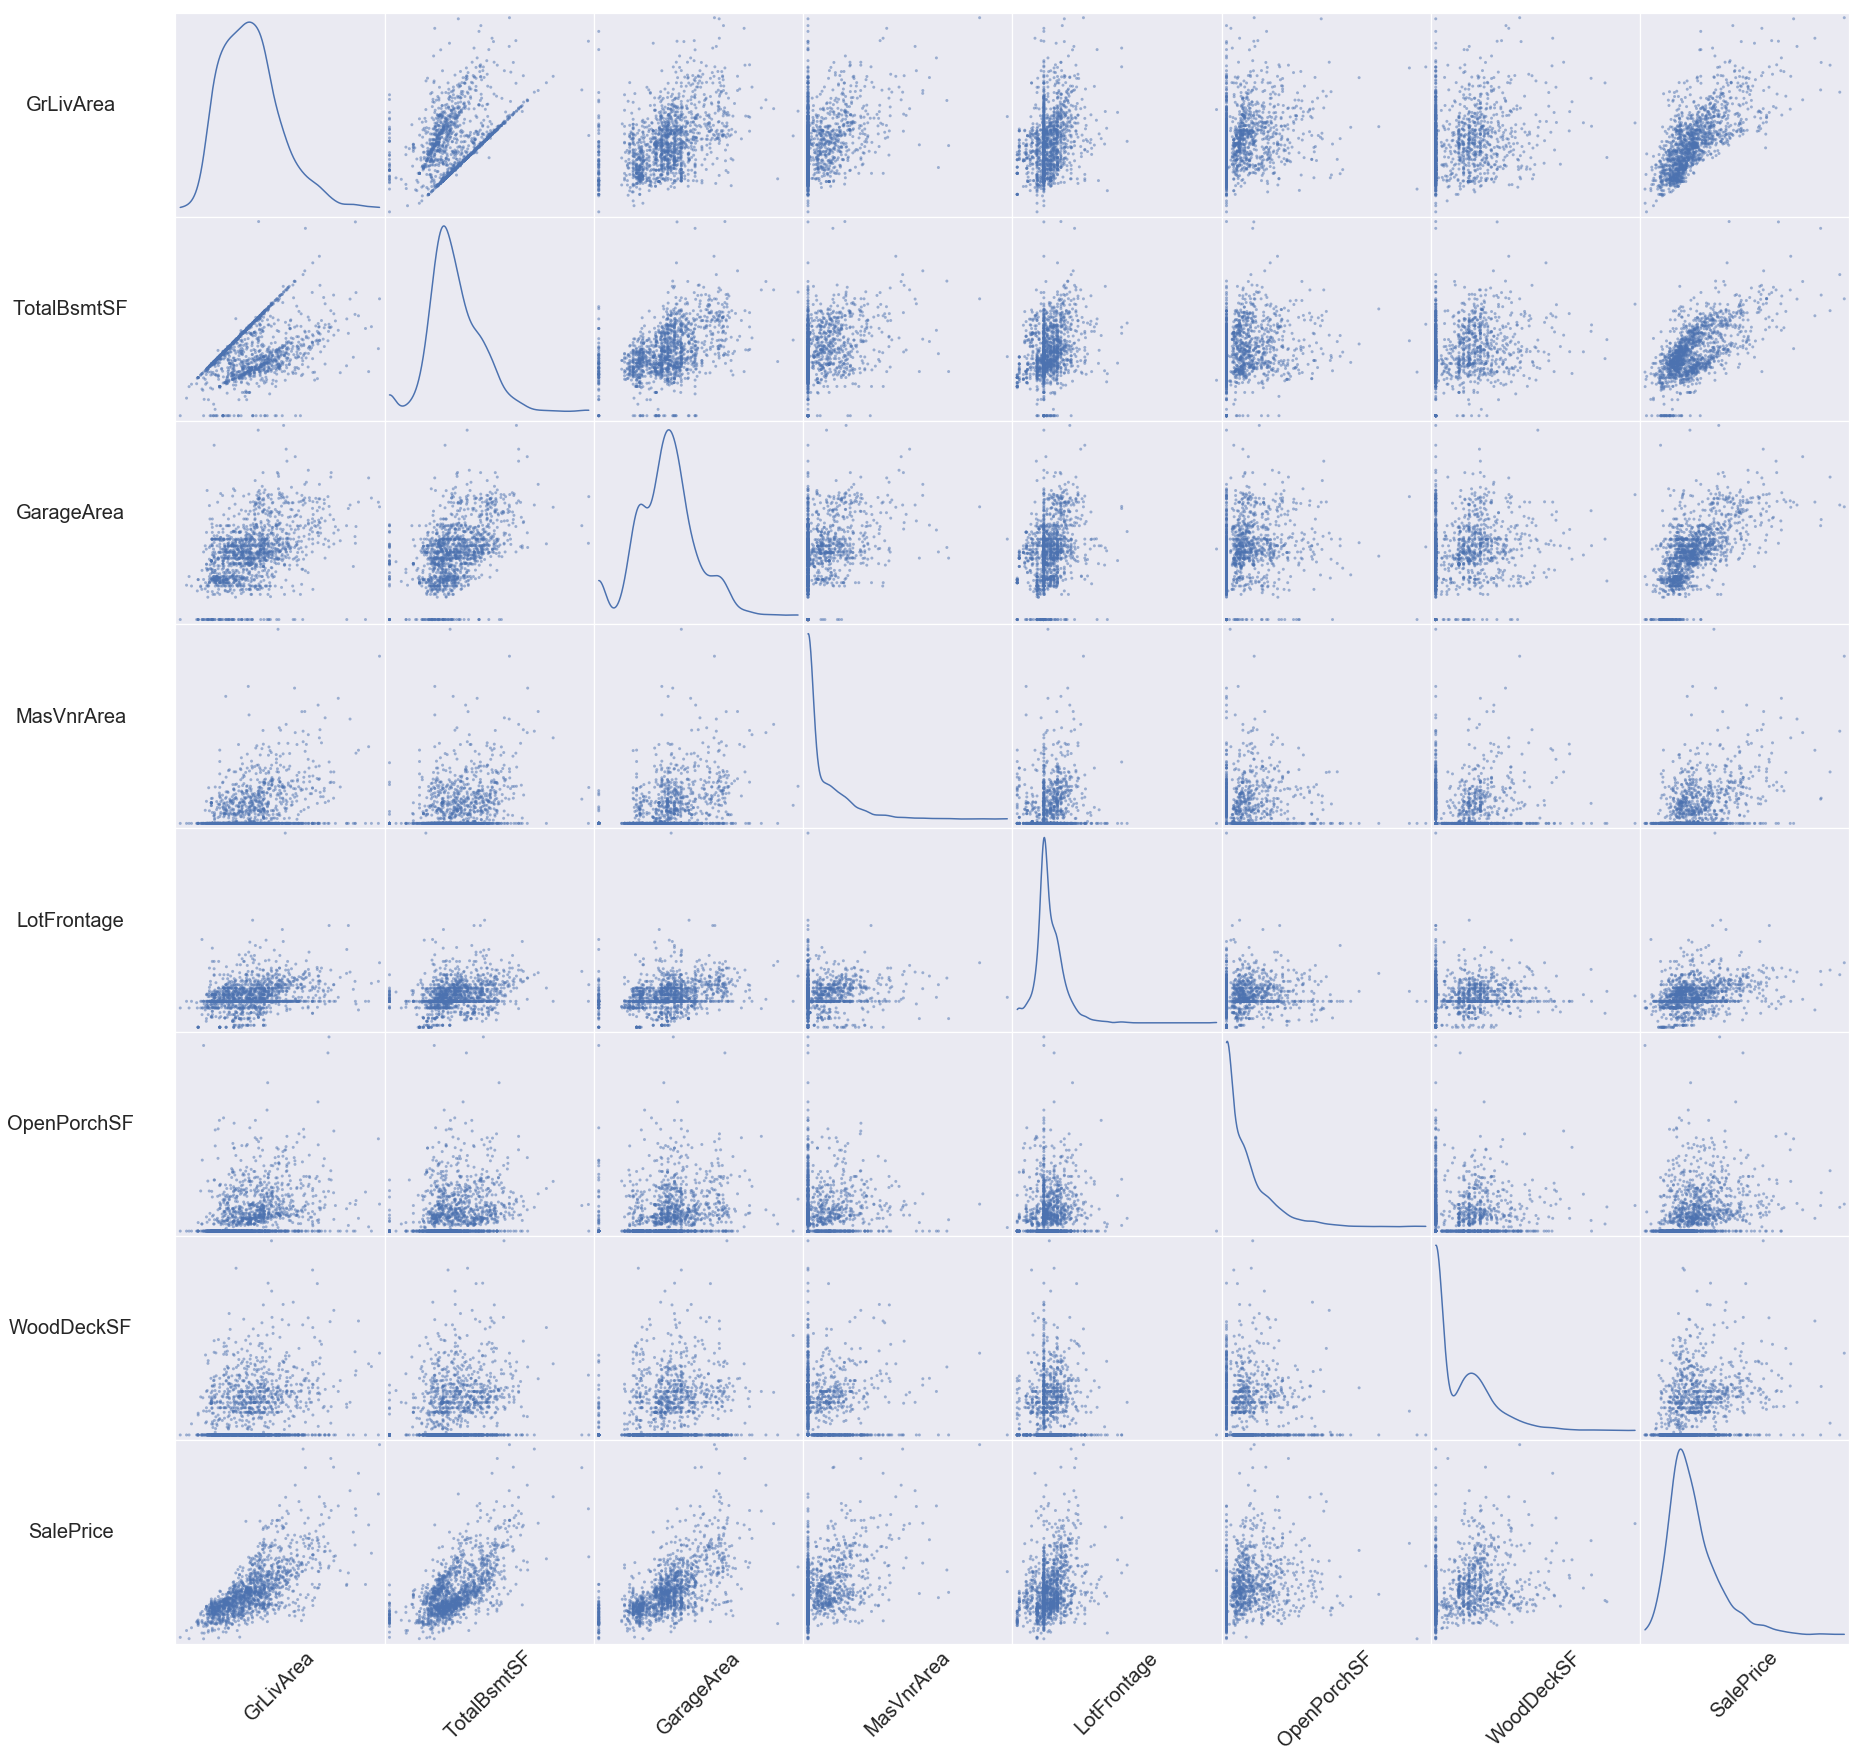

In [144]:
%config InlineBackend.figure_format = 'png' 
sm = pd.plotting.scatter_matrix(df_train[imp_cont_features + ['SalePrice']], figsize=(30, 30), diagonal='kde');

for ax in sm.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 0)

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

From the the above scatter matrix we can see the distributions of the features correlated to our target variable as well as  the density plot for each variable.

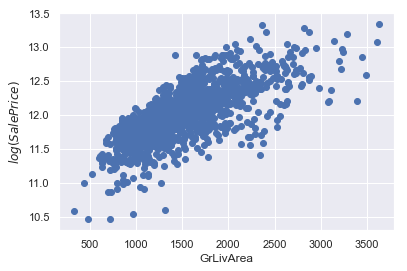

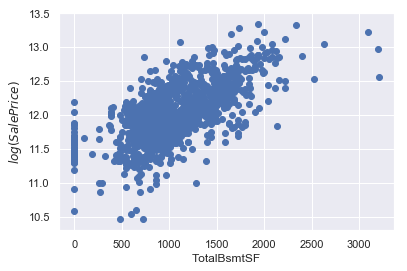

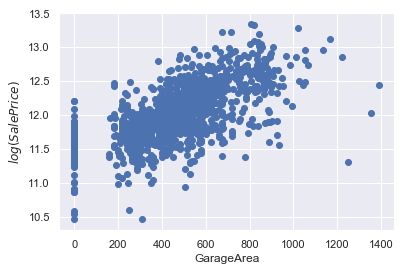

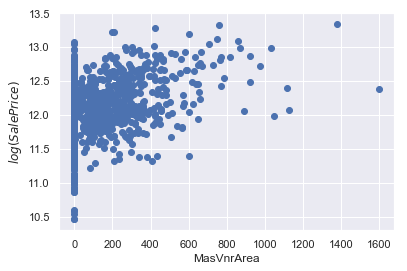

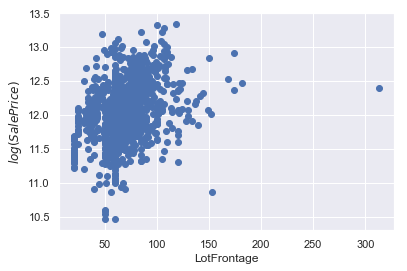

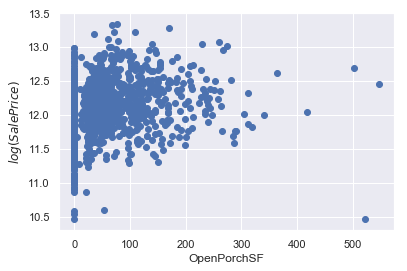

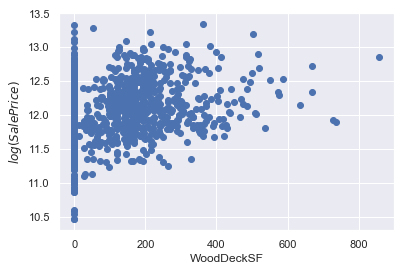

In [145]:
for feat in imp_cont_features:
    plt.scatter(df_train[feat], np.log(df_train.SalePrice))
    plt.xlabel(feat)
    plt.ylabel('$log(Sale Price)$')
    plt.show()

#### Baseline Model

Let's try to fit a Linear Regression by simply taking into consideration the neighborhood and total square footage:
* Neighborhood
* TotalBsmtSF + GrLivArea

#### TotalSquareFootage

In [146]:
df_train['TotalSquareFootage'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']
df_test['TotalSquareFootage'] = df_test['GrLivArea'] + df_test['TotalBsmtSF']

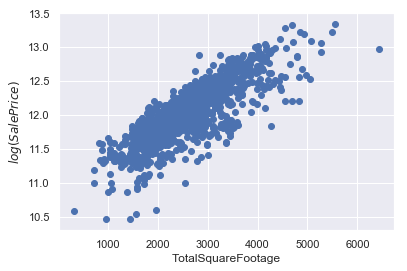

In [147]:
plt.scatter(df_train['TotalSquareFootage'], np.log(df_train.SalePrice))
plt.xlabel('TotalSquareFootage')
plt.ylabel('$log(Sale Price)$')
plt.show()

In [148]:
df_train['logSalePrice'] = np.log(df_train.SalePrice)

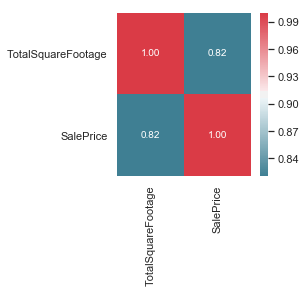

In [149]:
# calculate correlation matrix
corr = df_train[['TotalSquareFootage', 'SalePrice']].corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(3,3))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
g = sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
# plt.xticks(range(len(corr.columns)), corr.columns);
# #Apply yticks
# plt.yticks(range(len(corr.columns)), corr.columns)
# #show plot
plt.show()

We can see here that SalePrice has a strong positive linear relation with TotalSquareFootage, with a Correlation Coefficient of 0.82. I will use this continuous variable in my first simple model.

### Fit a Simple Linear Model

In [150]:
import statsmodels.api as sm

#### #1 Create an intercept

In [151]:
df_train['intercept'] = 1

In [152]:
X = df_train[['intercept', 'TotalSquareFootage']]
y = df_train['SalePrice']

In [153]:
# predicting the price and add all of our var that are quantitative
lm = sm.OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     3009.
Date:                Thu, 23 May 2019   Prob (F-statistic):               0.00
Time:                        16:18:27   Log-Likelihood:                -17626.
No. Observations:                1456   AIC:                         3.526e+04
Df Residuals:                    1454   BIC:                         3.527e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept          -3.159e+04   4027.310     -7.845      0.000   -3.95e+04   -2.37e+04
TotalSquareFootage    82.8049      1.510     54.852      0.000      79.844      85.766
==============================================================================
Omnibus:                      127.495   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.153
Skew:                           0.214   Prob(JB):                    3.30e-143
Kurtosis:                       6.261   Cond. No.                     9.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based only on the total square footage we get a R-squared of 0.674. This means that 67,4 % of the variability in SalePrice is explained by `TotalSquareFootage`

In [154]:
# these are our cofficients for our function
np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)) , X.transpose()), y)

array([-31594.19591877,     82.80489695])

$yhat = 82.80489695x - 31594.19591877$

#### #Add Neighborhood Dummies

In [155]:
df_train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [156]:
# create neighborhood dummies
neighborhood_dummies = pd.get_dummies(df_train['Neighborhood'])
neighborhood_dummies.head()

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Fit a regression model with Bloomington Heights as Baseline

In [157]:
# select all the columns but the first
neighborhood_columns = list(neighborhood_dummies.columns[1:])
neighborhood_dummies[neighborhood_columns].head()

,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [158]:
X = X.join(neighborhood_dummies)
X.head()

,intercept,TotalSquareFootage,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,2566,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,2706,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2473,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,3343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [159]:
y = df_train['SalePrice']

In [160]:
lm2 = sm.OLS(y, X[['intercept', 'TotalSquareFootage'] + neighborhood_columns])
results2 = lm2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     223.0
Date:                Thu, 23 May 2019   Prob (F-statistic):               0.00
Time:                        16:18:28   Log-Likelihood:                -17285.
No. Observations:                1456   AIC:                         3.462e+04
Df Residuals:                    1430   BIC:                         3.476e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept           2.409e+04   9437.856      2.553      0.011    5577.367    4.26e+04
TotalSquareFootage    62.0487      1.507     41.174      0.000      59.093      65.005
Blueste            -1.261e+04   2.62e+04     -0.482      0.630   -6.39e+04    3.87e+04
BrDale             -2.676e+04   1.23e+04     -2.180      0.029   -5.08e+04   -2684.911
BrkSide             -2.14e+04   9712.334     -2.203      0.028   -4.05e+04   -2346.736
ClearCr             1430.8718   1.08e+04      0.133      0.894   -1.97e+04    2.25e+04
CollgCr             1.018e+04   8946.717      1.138      0.255   -7365.129    2.77e+04
Crawfor             1.128e+04   9789.641      1.152      0.250   -7926.997    3.05e+04
Edwards             -2.62e+04   9238.217     -2.836      0.005   -4.43e+04   -8078.985
Gilbert               1.3e+04   9352.402      1.390      0.165   -5345.791    3.13e+04
IDOTRR             -4.119e+04   1.03e+04     -3.989      0.000   -6.14e+04   -2.09e+04
MeadowV            -3.176e+04   1.21e+04     -2.627      0.009   -5.55e+04   -8041.908
Mitchel            -1.605e+04   9854.085     -1.629      0.104   -3.54e+04    3278.639
NAmes              -2.322e+04   8814.296     -2.634      0.009   -4.05e+04   -5929.080
NPkVill            -1.704e+04   1.44e+04     -1.181      0.238   -4.54e+04    1.13e+04
NWAmes             -1.384e+04   9415.067     -1.470      0.142   -3.23e+04    4627.376
NoRidge             5.053e+04   1.03e+04      4.909      0.000    3.03e+04    7.07e+04
NridgHt             7.384e+04   9437.698      7.824      0.000    5.53e+04    9.24e+04
OldTown            -3.795e+04   9119.576     -4.162      0.000   -5.58e+04   -2.01e+04
SWISU              -4.582e+04    1.1e+04     -4.170      0.000   -6.74e+04   -2.43e+04
Sawyer             -2.272e+04   9440.163     -2.407      0.016   -4.12e+04   -4205.239
SawyerW             -260.5056   9623.680     -0.027      0.978   -1.91e+04    1.86e+04
Somerst             3.191e+04   9277.756      3.440      0.001    1.37e+04    5.01e+04
StoneBr             7.531e+04    1.1e+04      6.827      0.000    5.37e+04     9.7e+04
Timber              2.556e+04   1.02e+04      2.503      0.012    5530.148    4.56e+04
Veenker             3.717e+04   1.35e+04      2.748      0.006    1.06e+04    6.37e+04
==============================================================================
Omnibus:                      254.693   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1536.401
Skew:                           0.667   Prob(JB):                         0.00
Kurtosis:                       7.852   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is corr

In [161]:
'{0:.10f}'.format(-4.119e+04)

'-41190.0000000000'

#### Conclusions for Neighborhood Blmngtn

1. 79.6% of the variability in price can be explained by the linear model built using total square footage and neighborhood.
2. For each additional unit increase in TotalSquareFootage, the price is expected to increase by 62 dollars as long as all the other variables stay the same.
3. We expect that a house in NridgHt will cost 75310 more than a house in Blmngtn, all else being equal.
4.  We expect that a house in SWISU will cost 41190 less than a house in Blmngtn, all else being equal.

#### sklearn

* let's use the sklearn Ordinary Least Squares Linear Regression
* fit the logarithm of SalePrice: `logSalePrice`

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [163]:
X.drop(columns=['intercept'], inplace=True)
y = df_train['logSalePrice']

In [164]:
reg = LinearRegression()
# fit training data
reg.fit(X, y)
# get the R^2
reg.score(X, y)

0.8058959386808628

In [165]:
# get the coefficients
reg.coef_

array([ 3.16336446e-04,  8.25947039e-02, -3.20947079e-02, -2.14619750e-01,
       -1.59127301e-01,  7.01637994e-02,  1.12966981e-01,  9.70121153e-02,
       -1.70681778e-01,  1.45539338e-01, -3.66864629e-01, -2.83290156e-01,
       -3.79121618e-02, -8.72204694e-02, -4.12205987e-02,  2.89720047e-03,
        1.95634938e-01,  2.90141805e-01, -2.36683218e-01, -2.15476509e-01,
       -9.51094792e-02,  4.49322603e-02,  2.16841245e-01,  2.93132720e-01,
        1.65428964e-01,  2.23014688e-01])

In [166]:
# get the intercept
reg.intercept_

11.216151365683729

In [167]:
# make predictions
pred = reg.predict(X)

#### Evaluate our base model

Let's calculate [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) 
* between the logarithm of the predicted value and the logarithm of the observed sales price. 

**Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.**

In [168]:
# calculate RMSE
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [169]:
# error
rmse(y, pred)

0.17444192264828137

In [170]:
# calculate RMSE
# np.sqrt(mean_squared_error(y, pred))

#### Submit Predictions

In [171]:
# load the dataset
PATH_TO_DATA = 'input'

sub = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'sample_submission.csv'), index_col='Id')

In [172]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSquareFootage
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NoFireplaceQu,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NoPool,MnPrv,NoMiscFeature,0,6,2010,WD,Normal,1778.0
1462,20,RL,81.0,14267,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NoFireplaceQu,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NoPool,NoFence,Gar2,12500,6,2010,WD,Normal,2658.0
1463,60,RL,74.0,13830,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NoPool,MnPrv,NoMiscFeature,0,3,2010,WD,Normal,2557.0
1464,60,RL,78.0,9978,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NoPool,NoFence,NoMiscFeature,0,6,2010,WD,Normal,2530.0
1465,120,RL,43.0,5005,Pave,NoAlley,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NoFireplaceQu,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NoPool,NoFence,NoMiscFeature,0,1,2010,WD,Normal,2560.0


In [173]:
# create neighborhood dummies
neighborhood_dummies_test = pd.get_dummies(df_test['Neighborhood'])
neighborhood_dummies_test.head()

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,
1461,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1462,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1463,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1464,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [174]:
X_test = df_test[['TotalSquareFootage']]
X_test = X_test.join(neighborhood_dummies_test)
X_test.head()

,TotalSquareFootage,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,1778.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1462,2658.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1463,2557.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1464,2530.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1465,2560.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [175]:
# make predictions
pred_test = reg.predict(X_test)
# exponentiate the results
pred_test = np.exp(pred_test)
pred_test[:10]

array([119536.50654836, 157905.67981806, 193022.68439977, 191381.08194056,
       223933.71872521, 184719.22171444, 181074.35637236, 175380.47811562,
       198220.4864839 , 119008.28453125])

In [176]:
sub['SalePrice'] = pred_test

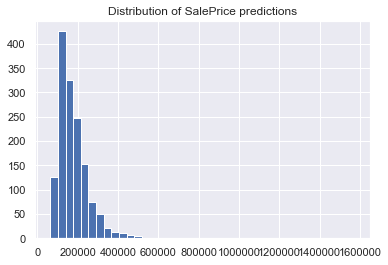

In [177]:
plt.hist(pred_test, bins=40);
plt.title('Distribution of SalePrice predictions');

In [178]:
sub.to_csv('submissions/model1.csv')
# load the dataset

model1_sub = pd.read_csv(os.path.join('submissions', 
                                             'model1.csv'), index_col='Id')
model1_sub.head() # 0.19363

,SalePrice
Id,
1461,119536.506548
1462,157905.679818
1463,193022.684400
1464,191381.081941
1465,223933.718725


<a id="conclusions"></a>
## Conclusions

Fitting the clean data to a simple **Linear Regression Model** in order to make a baseline model for further improvements. Using only two variables I was able to make a simple model with a **Coefficient of Determination  (R Squared)** of about 0.80. I first applied a log transformation on our target variable to make it normally distributed and then I fitted my input variables to the linear model. The two variables used in the regression are the Total Square Footage (`TotalBsmtS`F + `GrLivArea`) and the `Neighborhood`. On the second variable I used one-hot-encoding. The model was evaluated with `Root Mean Squared Error (RMSE)` with a value of about 0.17444 on the training set and 0.19363 on the testing set on the Kaggle House Prices Competition. 
This is just a baseline model which has great room for improvement and creativity on feature engineering. This model used only two features and in the dataset there are 79. Also, there are other models that should be used like XGBoost, CatBoost, LightGBM, ElasticNet and others. Stacking the results of these models and hyperparameter tuning are the next steps for a second more complex model with better predictions.